# Setup

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Loading data

In [48]:
#dataset for student information
enroll=pd.read_excel('Enrollment_reading.xls')

#datasets for scores from different periods of time
jan20=pd.read_excel('ScoreCardjan2020.xlsx')
july19=pd.read_excel('ScoreCardjuly2019.xlsx')
mar19=pd.read_excel('ScoreCardmar2019.xlsx')
may20=pd.read_excel('ScoreCardmay2020.xlsx')
nov19=pd.read_excel('ScoreCardnov2019.xlsx')
sept19=pd.read_excel('ScoreCardsept2019.xlsx')

#append all score datasets into one dataframe
score=jan20.append(july19)
score=score.append(mar19)
score=score.append(may20)
score=score.append(nov19)
score=score.append(sept19)

#dataset with Kumon tasks and BERT results
bert=pd.read_excel('KumonTaskData_BERTResults.xlsx')

WARNING *** file size (41221) not 512 + multiple of sector size (512)


### Processing data

In [53]:
#make age column for enrollment df
enroll['age']=2020-enroll['DateOfBirth'].dt.year
#keep relevant columns only
enroll2=enroll[['StudentID','GradeLevel','Gender','KumonGradeLevel',
                'age']]
#transform gender column to 1 if male and 0 if female
enroll2['Gender']=[1 if x=='M' else 0 for x in enroll2['Gender']]

#ignore first 12 rows, which have no studentID
enroll2=enroll2.iloc[12:,:]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [56]:
#make both columns same type for merging
score['StudentID']=score['StudentID'].astype(int)
enroll2['StudentID']=enroll2['StudentID'].astype(int)
#merge dataframes to get age
score=score.merge(enroll2, on='StudentID',how='left')

In [61]:
#keep relevant columns only
scores=score[['StudentID','KumonGradeLevel_x','WkFrom','WkTo','Wk1Score','Wk2Score','Wk3Score',
              'Wk4Score','Wk5Score','Wk6Score','Wk7Score','Wk8Score','Wk9Score',
               'Wk10Score','age']]
scores=scores.rename(columns={'KumonGradeLevel_x':'KumonGradeLevel'})
#keep students in relevant gradelevels only
scores =scores[scores['KumonGradeLevel'].isin(['AI','AII','BI','BII',
                                             'CI','CII'])]
enroll2 =enroll2[enroll2['KumonGradeLevel'].isin(['AI','AII','BI','BII',
                                             'CI','CII'])]
#drop students that don't have data on either grade level or work assignment
scores.dropna(subset=['WkTo','WkFrom','KumonGradeLevel'])
scores=scores.reset_index()

#make a column that contains the first and last work pages assigned
scores['WkPgs']=[(scores.iloc[i,3],scores.iloc[i,4]) for i in range(len(scores))]

In [62]:
#define a function to determine which work-page group the student is assigned to
def extract_level(wkfrom,wkto):
    length=wkto-wkfrom
    possible=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190]
    if length > 10:
        return 'More than 1 level'
    else:
        f= lambda x: abs(wkfrom-x)
        l=[f(x) for x in possible]
        return min(possible,key=f)

In [63]:
#add a column to scores df indicating which page-group the assignment belongs to
scores['Level']=[extract_level(w[0],w[1]) for w in scores['WkPgs']]

In [68]:
#group scores by Kumon grade level and page-group
s=scores.groupby(['KumonGradeLevel','Level'])
list_score=['Wk1Score','Wk2Score','Wk3Score',
              'Wk4Score','Wk5Score','Wk6Score','Wk7Score','Wk8Score','Wk9Score',
               'Wk10Score']

#make a dictionary with Kumon grade level, page group, and page number as key 
#and average score and number of observed scores as value 
dic={}
for key in s.groups.keys():
    df=s.get_group(key)
    for page in list_score:
        k=(key,page)
        l=df[page].dropna()
        l=[s for s in l if s !=0]
        dic[k]=[np.mean(l),len(l)]

In [71]:
ss=pd.Series(dic)
#make dictionary a dataframe
scores_by_page=ss.to_frame()
scores_by_page=scores_by_page.rename(columns={0:'Avg Score, # Instances'})
#returns df in descending order of average score
scores_by_page.sort_values('Avg Score, # Instances')

Avg Score, # Instances
(CII, 150) Wk8Score    [72.78571428571429, 14]
(CII, 160) Wk8Score    [73.76923076923077, 13]
(CI, 20)   Wk7Score     [74.1025641025641, 39]
(CI, 0)    Wk9Score     [74.16666666666667, 6]
           Wk8Score     [74.16666666666667, 6]
(CI, 70)   Wk3Score                 [75.2, 35]
(CII, 130) Wk7Score                 [76.0, 15]
           Wk6Score    [76.06666666666666, 15]
(CI, 70)   Wk5Score    [76.08823529411765, 34]
(CII, 140) Wk6Score    [76.41666666666667, 12]
(CII, 160) Wk6Score    [76.46153846153847, 13]
(CI, 10)   Wk5Score    [76.51351351351352, 37]
           Wk9Score    [76.86486486486487, 37]
           Wk7Score    [77.10526315789474, 38]
(CII, 160) Wk9Score    [77.15384615384616, 13]
(CII, 60)  Wk4Score    [77.15384615384616, 13]
(CII, 70)  Wk8Score    [77.21428571428571, 14]
(CI, 10)   Wk4Score    [77.32432432432432, 37]
(CI, 50)   Wk10Score   [77.38888888888889, 36]
(CI, 20)   Wk5Score    [77.43243243243244, 37]
(CI, 50)   Wk7Score    [77.48571428571428, 35]
(CI, 70)   Wk4Score    [77.54285714285714, 35]
(BII, 120) Wk3Score    [77.55555555555556, 27]
(CI, 30)   Wk8Score    [77.97297297297297, 37]
(CII, 10)  Wk7Score    [78.05555555555556, 18]
(CII, 20)  Wk9Score    [78.06666666666666, 15]
(CI, 30)   Wk7Score    [78.16216216216216, 37]
(BII, 10)  Wk5Score    [78.18604651162791, 43]
(CI, 80)   Wk7Score    [78.20588235294117, 34]
(CII, 100) Wk3Score    [78.23529411764706, 17]
...                                        ...
(AII, 100) Wk3Score                [100.0, 39]
           Wk5Score                [100.0, 39]
(AII, 140) Wk1Score                [100.0, 40]
(AII, 120) Wk1Score                [100.0, 40]
(AII, 40)  Wk1Score                [100.0, 42]
(BI, 80)   Wk1Score                [100.0, 42]
           Wk2Score                [100.0, 42]
           Wk3Score                [100.0, 42]
           Wk4Score                [100.0, 42]
(AI, 110)  Wk1Score                [100.0, 45]
           Wk2Score                [100.0, 45]
           Wk3Score                [100.0, 45]
(AII, 20)  Wk1Score                [100.0, 45]
(AI, 110)  Wk4Score                [100.0, 45]
(AII, 70)  Wk1Score                [100.0, 46]
(AII, 0)   Wk1Score                [100.0, 47]
(AII, 80)  Wk1Score                [100.0, 50]
(BI, 90)   Wk1Score                [100.0, 52]
(BI, 150)  Wk1Score                [100.0, 53]
(AI, 140)  Wk1Score                [100.0, 57]
(AI, 100)  Wk1Score                [100.0, 60]
(AI, 20)   Wk1Score                [100.0, 60]
(AI, 30)   Wk1Score                [100.0, 61]
(AI, 10)   Wk1Score                [100.0, 62]
(AI, 70)   Wk1Score                [100.0, 62]
(BI, 40)   Wk1Score                [100.0, 63]
(BI, 20)   Wk1Score                [100.0, 65]
(AI, 0)    Wk1Score                [100.0, 66]
(CI, 160)  Wk6Score   [102.78260869565217, 23]
(CII, 180) Wk3Score   [104.64285714285714, 14]

[1200 rows x 1 columns]

In [72]:
print(scores_by_page.filter(like='AII', axis=0).sort_values('Avg Score, # Instances', ascending=True).to_string())

                       Avg Score, # Instances
(AII, 120) Wk3Score              [82.875, 40]
(AII, 80)  Wk5Score    [83.3921568627451, 51]
           Wk4Score               [83.68, 50]
(AII, 150) Wk5Score   [85.10526315789474, 38]
(AII, 60)  Wk5Score   [85.72916666666667, 48]
(AII, 140) Wk5Score               [86.75, 40]
(AII, 90)  Wk5Score   [87.02272727272727, 44]
(AII, 110) Wk3Score   [87.14634146341463, 41]
(AII, 90)  Wk2Score               [87.25, 44]
(AII, 110) Wk4Score               [87.75, 40]
(AII, 70)  Wk3Score   [88.08695652173913, 46]
(AII, 120) Wk5Score               [88.35, 40]
(AII, 150) Wk2Score   [88.39473684210526, 38]
(AII, 70)  Wk4Score   [88.42222222222222, 45]
(AII, 80)  Wk2Score                [88.6, 50]
(AII, 70)  Wk5Score   [89.15217391304348, 46]
(AII, 80)  Wk3Score               [89.24, 50]
(AII, 120) Wk2Score                [90.1, 40]
(AII, 90)  Wk9Score             [90.3125, 48]
(AII, 110) Wk10Score             [90.475, 40]
(AII, 140) Wk8Score   [90.52777777

In [168]:
scores_by_page.xs(key=('AII', 140))

,0
Wk1Score,"[100.0, 40]"
Wk2Score,"[96.475, 40]"
Wk3Score,"[95.5, 40]"
Wk4Score,"[92.35, 40]"
Wk5Score,"[86.75, 40]"
Wk6Score,"[94.13888888888889, 36]"
Wk7Score,"[94.69444444444444, 36]"
Wk8Score,"[90.52777777777777, 36]"
Wk9Score,"[98.54285714285714, 35]"
Wk10Score,"[94.55555555555556, 36]"


In [199]:
scores_by_page2=scores_by_page
scores_by_page2=scores_by_page2.rename(columns={'Avg Score, # Instances':'score average'})
#get a dataframe with just score average and no number of instances
scores_by_page2['score average']=[float(x[0]) for x in
    scores_by_page2['score average']]
scores_by_page2

score average
(AI, 0)    Wk1Score      100.000000
           Wk2Score       97.812500
           Wk3Score       97.171875
           Wk4Score       95.774194
           Wk5Score       95.306452
           Wk6Score       98.633333
           Wk7Score       94.966667
           Wk8Score       98.888889
           Wk9Score       97.777778
           Wk10Score      98.518519
(AI, 10)   Wk1Score      100.000000
           Wk2Score       96.774194
           Wk3Score       94.467742
           Wk4Score       95.258065
           Wk5Score       94.274194
           Wk6Score       98.483333
           Wk7Score       90.700000
           Wk8Score       97.491803
           Wk9Score       97.180328
           Wk10Score      95.721311
(AI, 20)   Wk1Score      100.000000
           Wk2Score       95.466667
           Wk3Score       95.250000
           Wk4Score       96.783333
           Wk5Score       95.677966
           Wk6Score       97.048387
           Wk7Score       94.725806
           Wk8Score       98.532258
           Wk9Score       99.016129
           Wk10Score      97.387097
...                             ...
(CII, 170) Wk1Score       94.166667
           Wk2Score       90.833333
           Wk3Score       94.166667
           Wk4Score       95.833333
           Wk5Score       94.444444
           Wk6Score       88.916667
           Wk7Score       85.583333
           Wk8Score       92.153846
           Wk9Score       89.857143
           Wk10Score      83.461538
(CII, 180) Wk1Score       87.857143
           Wk2Score       84.000000
           Wk3Score      104.642857
           Wk4Score       96.923077
           Wk5Score       83.615385
           Wk6Score       83.250000
           Wk7Score       91.666667
           Wk8Score       90.000000
           Wk9Score       89.076923
           Wk10Score      89.000000
(CII, 190) Wk1Score      100.000000
           Wk2Score      100.000000
           Wk3Score      100.000000
           Wk4Score      100.000000
           Wk5Score      100.000000
           Wk6Score       95.833333
           Wk7Score       95.833333
           Wk8Score       93.277778
           Wk9Score       92.578947
           Wk10Score      92.631579

[1200 rows x 1 columns]

In [206]:
#summary statistics for scores by page
scores_by_page2.describe()

,score average
count,1200.000000
mean,91.680948
std,6.181471
min,72.785714
25%,87.111221
50%,92.627265
75%,96.700676
max,104.642857


In [81]:
#score averages for Kumon grade level and page-group, sorted 
avgs=scores_by_page2.groupby(level=0).mean()
avgs.sort_values('score average')

,score average
"(CI, 10)",83.388905
"(CI, 0)",83.709206
"(CI, 70)",83.787611
"(CII, 160)",83.961538
"(BII, 30)",84.474486
"(CII, 10)",84.588958
"(CI, 30)",84.777853
"(CII, 70)",84.802363
"(CI, 50)",85.305696
"(CI, 20)",85.585223


In [89]:
level_avgs=avgs
level_avgs['level']=[x[0] for x in level_avgs.index]
#get score averages for entire Kumon grade levels
level_avgs=level_avgs.groupby('level').mean()

,score average
level,
AI,95.788275
AII,95.429876
BI,91.901971
BII,89.635884
CI,88.507010
CII,88.822673


In [84]:
enroll2.groupby('KumonGradeLevel').mean()

,StudentID,Gender,age
KumonGradeLevel,,,
AI,8.401904e+12,0.733333,8.133333
AII,8.401901e+12,0.666667,8.666667
BI,8.401867e+12,0.444444,8.500000
BII,8.401901e+12,0.500000,8.700000
CI,8.401867e+12,0.166667,8.666667
CII,8.401851e+12,0.000000,9.000000


## Comparison to BERT

In [112]:
#change NaNs in answers to correct
bert["BERT's Answers"].fillna("Correct", inplace = True)
#make column for indicator variable for correctness
bert['Correct']=[1 if x=='Correct' else 0 for x in bert["BERT's Answers"]]
#df with just kumon level and performance information
bert_levels=bert[['Kumon Level','Workbook Page','Average Score','Task',"Correct"]]
bert_levels['Assignment']=[(bert_levels.loc[i,'Kumon Level'],bert_levels.loc[i,'Workbook Page']) for i in range(len(bert_levels))]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [117]:
bert_scores=bert_levels.groupby('Assignment').agg({'Correct':'sum', 'Task':'count','Average Score':'mean'})

In [170]:
bert_scored=[69,100,80,80,69,70,69,69,69,70,70,69,69,69,69,69,69,69,69,69]
bert_scores['BERT Kumon Score']=bert_scored
bert_scores

,Correct,Task,Average Score,BERT Kumon Score
Assignment,,,,
"(AII, 138)",1,3,93.0,69
"(AII, 148)",3,3,90.5,100
"(BI, 39)",3,4,83.8,80
"(BI, 60)",3,4,83.2,80
"(BI, 78)",1,4,96.9,69
"(BI, 80)",2,4,93.2,70
"(BII, 39)",1,4,79.1,69
"(BII, 123)",1,4,77.6,69
"(BII, 139)",1,4,90.5,69


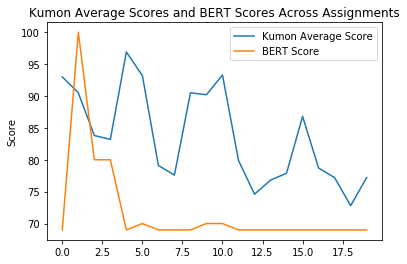

In [186]:
x=range(len(bert_scores))
y1=list(bert_scores['Average Score'])
y2=np.array(bert_scored)
plt.plot(x,y1,label='Kumon Average Score')
plt.plot(x,y2,label='BERT Score')
plt.ylabel("Score")
plt.title('Kumon Average Scores and BERT Scores Across Assignments')
plt.legend()

Text(0.5, 1.0, 'Difference between Kumon Average Score and BERT Score Across Assignments')

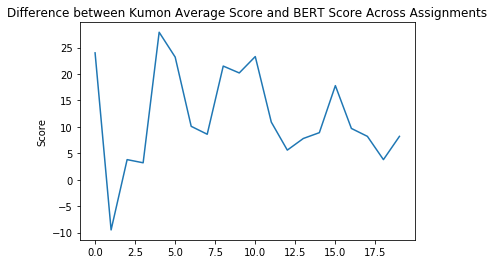

In [185]:
bert_scores['Score Diff.']=bert_scores['Average Score']-bert_scores['BERT Kumon Score']
plt.plot(x,bert_scores['Score Diff.'])
plt.ylabel("Score")
plt.title('Difference between Kumon Average Score and BERT Score Across Assignments')

Text(0, 0.5, 'Score')

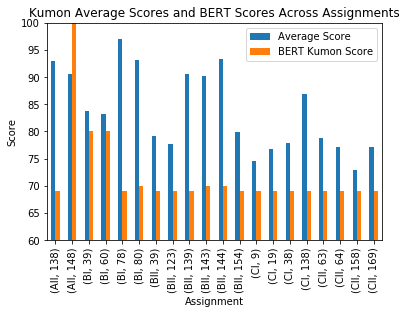

In [187]:
df2 = bert_scores[['Average Score', 'BERT Kumon Score']]
df2.plot.bar()
plt.ylim(60, 100)
plt.title('Kumon Average Scores and BERT Scores Across Assignments')
plt.ylabel("Score")